In [ ]:
import os
import time
import random
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm # Use notebook tqdm for Kaggle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import argparse
import kagglehub # Assuming kagglehub is installed and configured

# --- Configuration ---
# Using argparse for better hyperparameter management
parser = argparse.ArgumentParser(description='ViT Training for LFW from Scratch')
parser.add_argument('--img_size', type=int, default=128, help='Image size')
parser.add_argument('--patch_size', type=int, default=16, help='Patch size')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
parser.add_argument('--min_imgs', type=int, default=15, help='Minimum images per person to include') # Increased significantly
parser.add_argument('--embed_dim', type=int, default=512, help='Embedding dimension')
parser.add_argument('--depth', type=int, default=6, help='Number of transformer blocks') # Reduced depth slightly
parser.add_argument('--num_heads', type=int, default=8, help='Number of attention heads')
parser.add_argument('--mlp_ratio', type=float, default=4.0, help='MLP hidden dimension ratio')
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate') # Increased
parser.add_argument('--attn_dropout', type=float, default=0.3, help='Attention dropout rate') # Increased
parser.add_argument('--lr', type=float, default=1e-4, help='Maximum learning rate for OneCycleLR') # Reduced LR
parser.add_argument('--weight_decay', type=float, default=0.05, help='Weight decay (AdamW)') # Slightly increased WD
parser.add_argument('--epochs', type=int, default=100, help='Maximum number of epochs')
parser.add_argument('--patience', type=int, default=15, help='Early stopping patience') # Added early stopping
parser.add_argument('--seed', type=int, default=42, help='Random seed for reproducibility')
parser.add_argument('--data_dir', type=str, default=None, help='Path to dataset directory (will be set by kagglehub)')

# Kaggle notebooks often need this for argparse
# Use default args if not running from command line with arguments
args = parser.parse_args(args=[])

# --- Seed for Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(args.seed)

# --- Download Dataset ---
print("Downloading LFW dataset...")
# Use a temporary variable to store the path returned by kagglehub
dataset_download_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
args.data_dir = os.path.join(dataset_download_path, "lfw-deepfunneled/lfw-deepfunneled")
print(f"Dataset downloaded to: {dataset_download_path}")
print(f"Using image directory: {args.data_dir}")

# --- Dataset + Augmentation ---
# Stronger Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15), # Slightly increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1), # Stronger color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0), # Added Random Erasing
])

# Simple Augmentation for Validation
val_transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

class LFWDataset(Dataset):
    # Corrected __init__ definition
    def __init__(self, root_dir, transform=None, min_imgs=2):
        self.images = []
        self.labels = []
        self.transform = transform
        self.label_map = {}
        self.class_to_idx = {} # Keep track for mapping back if needed
        lbl_id = 0

        print(f"Loading dataset from {root_dir} with min_imgs={min_imgs}")
        if not os.path.isdir(root_dir):
             raise FileNotFoundError(f"Dataset directory not found: {root_dir}")

        # Iterate through person folders
        for person in os.listdir(root_dir):
            folder = os.path.join(root_dir, person)
            # Ensure it's a directory
            if not os.path.isdir(folder): continue

            imgs_in_folder = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() == '.jpg']
            # Filter based on minimum images
            if len(imgs_in_folder) < min_imgs: continue

            # Assign label ID if not already done
            if person not in self.label_map:
                self.label_map[person] = lbl_id
                self.class_to_idx[lbl_id] = person # Store reverse mapping
                lbl_id += 1

            # Add images and labels to lists
            person_label_id = self.label_map[person]
            for img_name in imgs_in_folder:
                self.images.append(os.path.join(folder, img_name))
                self.labels.append(person_label_id)

        self.num_classes = len(self.label_map)
        print(f"Found {len(self.images)} images belonging to {self.num_classes} individuals (with >= {min_imgs} images each).")
        if self.num_classes == 0:
            print(f"Warning: No classes found with min_imgs={min_imgs}. Check data_dir or lower min_imgs.")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder or skip? For now, let's return None and handle in DataLoader
            # Or, better, raise an error or return a dummy tensor if your training loop can handle it.
            # Let's create a dummy tensor matching expected output shape
            return torch.zeros((3, args.img_size, args.img_size)), -1 # Return invalid label

        if self.transform:
            img = self.transform(img)

        return img, label

# --- Instantiate + Split Dataset ---
# Important: Create separate dataset instances for train and val transforms
full_train_dataset = LFWDataset(args.data_dir, transform=train_transform, min_imgs=args.min_imgs)
full_val_dataset   = LFWDataset(args.data_dir, transform=val_transform,   min_imgs=args.min_imgs)

# Ensure we have data before proceeding
if len(full_train_dataset) == 0:
    raise ValueError("Dataset is empty. Check `min_imgs` or `data_dir`.")

NUM_CLASSES = full_train_dataset.num_classes
print(f"Number of classes after filtering: {NUM_CLASSES}")

# Check if NUM_CLASSES > 0 before splitting
if NUM_CLASSES == 0:
     raise ValueError("No classes found to train on.")
elif NUM_CLASSES == 1:
    print("Warning: Only one class found after filtering. Classification training needs at least 2 classes.")
    # Handle this case if needed (e.g., exit or change task)
    # For now, we'll let it proceed, but train/val split might be trivial

# Generate indices once based on the labels from one of the datasets (they share the same structure)
indices = list(range(len(full_train_dataset)))
labels_for_split = full_train_dataset.labels

# Perform train/validation split
# Handle cases with very few samples where stratify might fail or be less meaningful
test_size = 0.2
if len(indices) < 5: # Need at least 1 sample per split per class for stratification with 2 classes
    print("Warning: Very few samples, using simple split.")
    train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)
elif NUM_CLASSES > 1:
    try:
        train_idx, val_idx = train_test_split(indices,
                                            test_size=test_size,
                                            stratify=labels_for_split,
                                            random_state=args.seed)
    except ValueError as e:
         print(f"Stratified split failed ({e}), falling back to non-stratified split.")
         train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)
else: # Only one class
    train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)


# Create subset datasets using the generated indices
train_ds = torch.utils.data.Subset(full_train_dataset, train_idx)
val_ds   = torch.utils.data.Subset(full_val_dataset,   val_idx) # Use val_dataset for correct transforms

print(f"Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

# --- DataLoaders ---
# Handle potential errors in __getitem__ during loading
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[1] != -1, batch)) # Filter out problematic samples
    if not batch:
        return torch.tensor([]), torch.tensor([]) # Return empty tensors if batch is empty
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_fn) # Reduced num_workers for Kaggle
val_loader   = DataLoader(val_ds,   batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# --- ViT Model Definition (Corrected __init__) ---
class PatchEmbedding(nn.Module):
    # Corrected __init__
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        # Projection layer
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.n_patches, embed_dim))
        # Initialize positional embedding
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)


    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}x{W}) doesn't match model ({self.img_size}x{self.img_size})."

        # Project patches: [B, C, H, W] -> [B, E, H/P, W/P]
        x = self.proj(x)
        # Flatten and transpose: [B, E, H/P, W/P] -> [B, E, N] -> [B, N, E]
        x = x.flatten(2).transpose(1, 2)
        # Prepend class token: [B, 1, E] + [B, N, E] -> [B, N+1, E]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # Add positional embedding
        x = x + self.pos_embed
        return x

class TransformerEncoder(nn.Module):
    # Corrected __init__
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, drop=0.1, attn_drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_drop, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(drop),
        )
        # Note: Consider adding Stochastic Depth (DropPath) here for stronger regularization if needed

    def forward(self, x):
        # Self-Attention Block
        res = x
        x = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        x = res + attn_output # Residual connection

        # MLP Block
        res = x
        x = self.norm2(x)
        x = res + self.mlp(x) # Residual connection
        return x

class ViT(nn.Module):
     # Corrected __init__
    def __init__(self,
                 img_size=128,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 drop_rate=0.1,
                 attn_drop_rate=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        # Transformer Blocks
        self.blocks = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, mlp_ratio, drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)])
        # Final normalization and classifier head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity() # Handle num_classes=0 case

        # Weight initialization (important for training from scratch)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x) # [B, N+1, E]
        # Pass through transformer blocks
        for blk in self.blocks:
            x = blk(x)
        # Final normalization (on CLS token)
        x = self.norm(x[:, 0]) # [B, E]
        # Classification head
        x = self.head(x) # [B, num_classes]
        return x

# --- Setup Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure NUM_CLASSES is valid before creating the model
if NUM_CLASSES <= 0:
    raise ValueError(f"Invalid number of classes: {NUM_CLASSES}. Check dataset filtering.")


model = ViT(img_size=args.img_size,
            patch_size=args.patch_size,
            in_chans=3,
            num_classes=NUM_CLASSES,
            embed_dim=args.embed_dim,
            depth=args.depth,
            num_heads=args.num_heads,
            mlp_ratio=args.mlp_ratio,
            drop_rate=args.dropout,
            attn_drop_rate=args.attn_dropout).to(device)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss Function with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer (AdamW recommended for transformers)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args.lr, # This is max_lr for OneCycleLR
                              weight_decay=args.weight_decay)

# Scheduler: OneCycleLR is good for faster convergence but can sometimes overshoot.
# CosineAnnealingLR might be gentler if OneCycleLR causes instability.
steps_per_epoch = len(train_loader)
if steps_per_epoch == 0:
     raise ValueError("Train loader is empty. Cannot determine steps per epoch.")

scheduler = OneCycleLR(optimizer,
                       max_lr=args.lr,
                       steps_per_epoch=steps_per_epoch,
                       epochs=args.epochs,
                       pct_start=0.1, # Slightly longer warmup
                       anneal_strategy='cos')

# Gradient scaler for mixed precision (optional but recommended for speed/memory on modern GPUs)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# --- Training + Validation Loop ---
best_val_acc = 0.0
best_epoch = 0
epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} # Track history

print(f"Starting training for {args.epochs} epochs...")

for epoch in range(1, args.epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    t0 = time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{args.epochs} [Train]")

    for imgs, labels in pbar:
        # Skip batch if it became empty after filtering in collate_fn
        if imgs.nelement() == 0:
            continue

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()

        # Optional: Gradient Clipping (unscale first if using scaler)
        scaler.unscale_(optimizer) # Unscale before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        scheduler.step() # Step OneCycleLR *every iteration*

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

        pbar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})

    # Calculate epoch stats (handle division by zero if total is 0)
    train_loss = running_loss / total if total > 0 else 0
    train_acc  = correct / total if total > 0 else 0
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    t1 = time.time()

    # --- Validation ---
    model.eval()
    val_running_loss, val_corr, val_tot = 0.0, 0, 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{args.epochs} [Val]")

    with torch.no_grad():
        for imgs, labels in val_pbar:
            # Skip batch if it became empty after filtering in collate_fn
            if imgs.nelement() == 0:
                 continue

            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss   = criterion(logits, labels) # Calculate val loss too

            val_running_loss += loss.item() * imgs.size(0)
            preds  = logits.argmax(dim=1)
            val_corr += (preds == labels).sum().item()
            val_tot  += imgs.size(0)
            val_pbar.set_postfix({'val_acc': val_corr / val_tot if val_tot > 0 else 0})


    val_loss = val_running_loss / val_tot if val_tot > 0 else 0
    val_acc  = val_corr / val_tot if val_tot > 0 else 0
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f} | Time: {t1-t0:.1f}s")

    # --- Save Best Model & Early Stopping ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'num_classes': NUM_CLASSES,
            'class_to_idx': full_train_dataset.class_to_idx, # Save mapping
            'args': args # Save config
        }, "best_vit_lfw_scratch.pth")
        print(f"*** Best validation accuracy improved to {best_val_acc:.4f}. Model saved. ***")
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve ({val_acc:.4f} vs best {best_val_acc:.4f}). {epochs_no_improve}/{args.patience}")

    if epochs_no_improve >= args.patience:
        print(f"\nEarly stopping triggered after {epoch} epochs.")
        break

print(f"\nTraining finished.")
print(f"Best validation accuracy: {best_val_acc:.4f} achieved at epoch {best_epoch}")
print("Best model weights saved to best_vit_lfw_scratch.pth")

# You can plot the history later if needed
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title('Loss Curve')
# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train Acc')
# plt.plot(history['val_acc'], label='Val Acc')
# plt.legend()
# plt.title('Accuracy Curve')
# plt.show()

In [2]:
import os
import numpy as np
from PIL import Image # Make sure PIL is imported
from tqdm.notebook import tqdm
import torch
import torch.nn as nn # Need this if ViT definition uses it
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # Need this for val_transform definition context
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# --- Corrected Dataset Class ---
class LFWDataset(Dataset):
    # Accept img_size in init
    def __init__(self, root_dir, transform=None, min_imgs=2, img_size=128): # Add img_size here
        self.images = []
        self.labels = []
        self.transform = transform
        self.label_map = {}
        self.class_to_idx = {}
        self.img_size = img_size # Store img_size
        lbl_id = 0

    def _load_data(self, root_dir, min_imgs):
        # Actual data loading logic separated for clarity
        self.images = []
        self.labels = []
        self.label_map = {}
        self.class_to_idx = {}
        lbl_id = 0
        # print(f"Re-loading dataset structure from {root_dir} with min_imgs={min_imgs}")
        if not os.path.isdir(root_dir):
             raise FileNotFoundError(f"Dataset directory not found: {root_dir}")

        for person in os.listdir(root_dir):
            folder = os.path.join(root_dir, person)
            if not os.path.isdir(folder): continue
            imgs_in_folder = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() == '.jpg']
            if len(imgs_in_folder) < min_imgs: continue

            if person not in self.label_map:
                self.label_map[person] = lbl_id
                self.class_to_idx[lbl_id] = person
                lbl_id += 1

            person_label_id = self.label_map[person]
            for img_name in imgs_in_folder:
                self.images.append(os.path.join(folder, img_name))
                self.labels.append(person_label_id)

        self.num_classes = len(self.label_map)
        print(f"Found {len(self.images)} images belonging to {self.num_classes} individuals.")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Use self.img_size stored during init for the dummy tensor
            return torch.zeros((3, self.img_size, self.img_size)), -1

        if self.transform:
            img = self.transform(img) # Transform already handles resizing based on args.img_size

        return img, label

# --- Main Script ---
if __name__ == "__main__":
    # 1. Load Checkpoint
    checkpoint_path = "/kaggle/input/dlp-vit-model/pytorch/default/1/best_vit_lfw_scratch.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    print(f"Loading checkpoint from {checkpoint_path}...")
    # Set weights_only=True unless you specifically need to load arbitrary code/objects
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False) # Keep False if args object needs loading
    # Note: Consider setting weights_only=True in the future if possible for security

    # Extract saved arguments and metadata
    if 'args' not in checkpoint:
        raise KeyError("Checkpoint requires 'args' to recreate the environment.")
    args = checkpoint['args']

    # Set seed using the seed saved during training for reproducibility of the split
    set_seed(args.seed) # Assumes set_seed function is defined elsewhere
    print(f"Using loaded random seed: {args.seed}")

    best_val_acc_saved = checkpoint.get('best_val_acc', 'N/A')
    epoch_saved = checkpoint.get('epoch', 'N/A')
    class_to_idx = checkpoint.get('class_to_idx', None)
    num_classes = checkpoint.get('num_classes', None)

    if num_classes is None:
        if class_to_idx: num_classes = len(class_to_idx)
        else: raise ValueError("Cannot determine number of classes from checkpoint.")

    print(f"Checkpoint loaded: Best Acc {best_val_acc_saved:.4f} (Epoch {epoch_saved}), Classes: {num_classes}")
    print(f"Using dataset path from checkpoint: {args.data_dir}")
    if not os.path.exists(args.data_dir):
        print(f"Warning: Dataset path '{args.data_dir}' not found. Report generation might fail.")


    # 2. Recreate Test Environment (using the validation split as test for this example)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # !!! Critical Assumption: 'val_transform' object must exist from previous cells !!!
    if 'val_transform' not in globals():
        # Define it here if it doesn't exist, ensuring it uses args.img_size
        val_transform = transforms.Compose([
            transforms.Resize((args.img_size, args.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
    else:
        # Optional: Verify the existing transform uses the correct size if possible
        # This is hard without inspecting the transform object's internals easily
        pass

    # !!! Critical Assumption: 'LFWDataset' class is defined above !!!
    # Pass args.img_size during instantiation
    full_dataset = LFWDataset(args.data_dir, transform=val_transform, img_size=args.img_size)
    # Load data structure based on saved args
    full_dataset._load_data(args.data_dir, args.min_imgs)

    # --- REMOVE THE PROBLEMATIC LAMBDA LINE ---
    # LFWDataset.__getitem__ = lambda self, idx: ... # Delete this line

    # Make sure dataset loading was successful
    if full_dataset.num_classes == 0:
        raise ValueError("Re-created dataset has 0 classes. Check args.data_dir and args.min_imgs.")

    # Recreate the SAME train/validation/test split
    indices = list(range(len(full_dataset)))
    labels_for_split = full_dataset.labels
    test_size = 0.2
    val_size = 0.2 # Assuming you want a separate test set of the same size as validation

    if len(indices) < 5 or num_classes <= 1:
        train_idx, temp_idx = train_test_split(indices, test_size=val_size + test_size, random_state=args.seed)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=args.seed)
    else:
        try:
            train_idx, temp_idx = train_test_split(indices, test_size=val_size + test_size, stratify=labels_for_split, random_state=args.seed)
            val_labels = [labels_for_split[i] for i in temp_idx]
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=val_labels, random_state=args.seed)
        except ValueError:
            train_idx, temp_idx = train_test_split(indices, test_size=val_size + test_size, random_state=args.seed)
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=args.seed)

    test_ds = torch.utils.data.Subset(full_dataset, test_idx)

    # !!! Critical Assumption: 'collate_fn' function must be defined elsewhere !!!
    if 'collate_fn' not in globals():
        # print("Warning: 'collate_fn' not found, using default collation.")
        _collate_fn = None
    else:
        _collate_fn = collate_fn

    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=_collate_fn)
    print(f"Recreated test dataloader with {len(test_ds)} samples.")

    # 3. Instantiate Model and Load Weights (Needs pre-defined ViT class)
    # !!! Critical Assumption: 'ViT' class must be defined elsewhere !!!
    try:
        model = ViT(img_size=args.img_size, patch_size=args.patch_size, in_chans=3,
                    num_classes=num_classes, embed_dim=args.embed_dim, depth=args.depth,
                    num_heads=args.num_heads, mlp_ratio=args.mlp_ratio,
                    drop_rate=args.dropout, attn_drop_rate=args.attn_dropout)
    except NameError:
        raise NameError("The 'ViT' class (and its dependencies) must be defined before running this script.")

    if 'model_state_dict' not in checkpoint:
        raise KeyError("Checkpoint does not contain 'model_state_dict'.")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print("Model instantiated and weights loaded.")

    # --- Calculate Test Loss and Accuracy ---
    criterion = nn.CrossEntropyLoss()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            if imgs.nelement() == 0:
                continue
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / test_total if test_total > 0 else 0
    test_acc = test_correct / test_total if test_total > 0 else 0

    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # 4. Generate Predictions on the Test Set (Optional)
    print("\n--- Generating Predictions on Test Set ---")
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Test Predictions"):
            if imgs.nelement() == 0: continue
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    # 5. Generate and Print Classification Report for Test Set (Optional)
    if all_test_labels:
        print("\n--- Test Classification Report ---")
        target_names = None
        if class_to_idx:
            try:
                target_names = [class_to_idx[i] for i in range(num_classes)]
            except KeyError:
                print("Warning: class_to_idx mapping seems incomplete. Using generic labels.")
                target_names = [f"Class {i}" for i in range(num_classes)]
        else:
            print("Warning: Class names (class_to_idx) not found. Using generic labels.")
            target_names = [f"Class {i}" for i in range(num_classes)]

        present_labels = np.unique(all_test_labels + all_test_preds)
        filtered_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

        try:
            report = classification_report(
                all_test_labels, all_test_preds,
                labels=present_labels,
                target_names=filtered_target_names,
                zero_division=0
            )
            print(report)
            overall_accuracy = accuracy_score(all_test_labels, all_test_preds)
            print(f"\nOverall Test Accuracy (calculated): {overall_accuracy:.4f}")
        except Exception as e:
            print(f"Could not generate test classification report: {e}")
            if all_test_labels:
                overall_accuracy = accuracy_score(all_test_labels, all_test_preds)
                print(f"\nOverall Test Accuracy (calculated): {overall_accuracy:.4f}")

Loading checkpoint from /kaggle/input/dlp-vit-model/pytorch/default/1/best_vit_lfw_scratch.pth...
Using loaded random seed: 42
Checkpoint loaded: Best Acc 0.8122 (Epoch 87), Classes: 96
Using dataset path from checkpoint: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Using device: cuda
Found 3595 images belonging to 96 individuals.
Recreated test dataloader with 719 samples.
Model instantiated and weights loaded.


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Test Loss: 0.2387, Test Accuracy: 0.9666

--- Generating Predictions on Test Set ---


Test Predictions:   0%|          | 0/12 [00:00<?, ?it/s]


--- Test Classification Report ---
                           precision    recall  f1-score   support

             Colin_Powell       1.00      1.00      1.00        47
             Roh_Moo-hyun       0.86      1.00      0.92         6
             Meryl_Streep       1.00      1.00      1.00         3
            Jean_Chretien       0.92      1.00      0.96        11
              Hugo_Chavez       0.93      1.00      0.97        14
           Pierce_Brosnan       1.00      1.00      1.00         3
    Arnold_Schwarzenegger       1.00      0.78      0.88         9
                Hans_Blix       1.00      1.00      1.00         8
        Gerhard_Schroeder       1.00      1.00      1.00        22
               Kofi_Annan       1.00      1.00      1.00         6
               Laura_Bush       1.00      1.00      1.00         8
        Lindsay_Davenport       1.00      1.00      1.00         5
              Carlos_Moya       1.00      1.00      1.00         4
              Tiger_Woods

Actual Class: Arnold Schwarzenegger


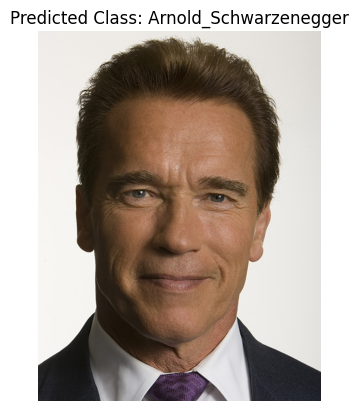

In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation to match the input size and normalization
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),  # Resize the image to the same size as the model's input
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize with the same values used during training
])

# Function to predict the image
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    original_img = img.copy()
    
    img = transform(img)  # Apply transformations

    # Add batch dimension (1, C, H, W)
    img = img.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make a prediction
    with torch.no_grad():
        logits = model(img)
        prediction = logits.argmax(dim=1)  # Get the predicted class label

    return prediction.item(), original_img

# Example 1 (True)
image_path = "/kaggle/input/testing-individuals/Test_3.jpg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Arnold Schwarzenegger")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

Actual Class: Donald Rumsfeld


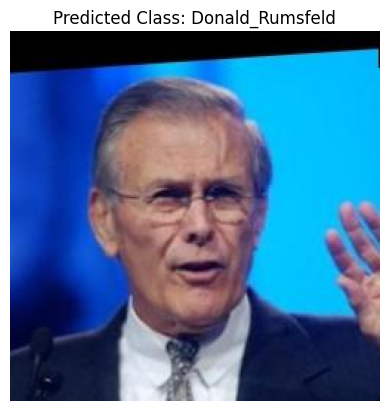

In [4]:
# Example 2 (True)
image_path = "/kaggle/input/testing-individuals/Test_6.jpg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Donald Rumsfeld")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

Actual Class: Jennifer Lopez


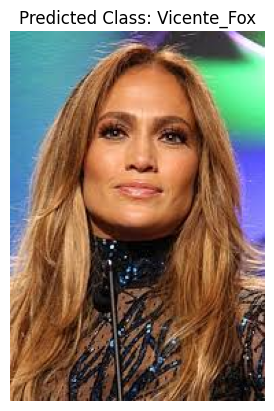

In [5]:
# Example 3 (False)
image_path = "/kaggle/input/testing-individuals/Test_7.jpeg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Jennifer Lopez")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()